/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.0494 - loss: 3.8212 - val_accuracy: 0.1154 - val_loss: 2.8763
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.1260 - loss: 2.7708 - val_accuracy: 0.4952 - val_loss: 2.1299
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.4592 - loss: 1.8738 - val_accuracy: 0.8173 - val_loss: 0.9114
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 328ms/step - accuracy: 0.7381 - loss: 0.8942 - val_accuracy: 0.9615 - val_loss: 0.2054
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.8362 - loss: 0.4570 - val_accuracy: 0.9760 - val_loss: 0.1510
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Classification Report:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00        12
           6       1.00      0.

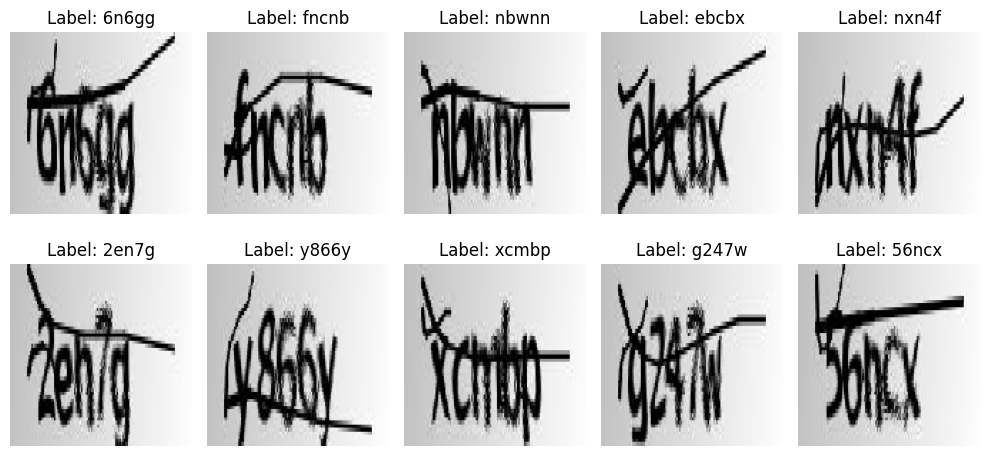

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to CAPTCHA images
data_dir = '/kaggle/input/captcha-version-2-images/samples'
image_size = (128, 128)

# Load images and labels
def load_captcha_images(data_dir):
    images = []
    labels = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):
            label = filename.split('.')[0]  # '226md'
            img_path = os.path.join(data_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img = img_to_array(img) / 255.0  # normalize
            images.append(img)
            labels.append(label)
    return np.array(images), labels

X, raw_labels = load_captcha_images(data_dir)

# Let's consider only the first character for now to simplify the classification task
y = [label[0] for label in raw_labels]

# Encode labels
unique_chars = sorted(set(y))
char_to_index = {char: idx for idx, char in enumerate(unique_chars)}
y_encoded = np.array([char_to_index[char] for char in y])
y_cat = to_categorical(y_encoded)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(unique_chars), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5)

# Predict
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=unique_chars))

# Show sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i])
    plt.title(f"Label: {raw_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


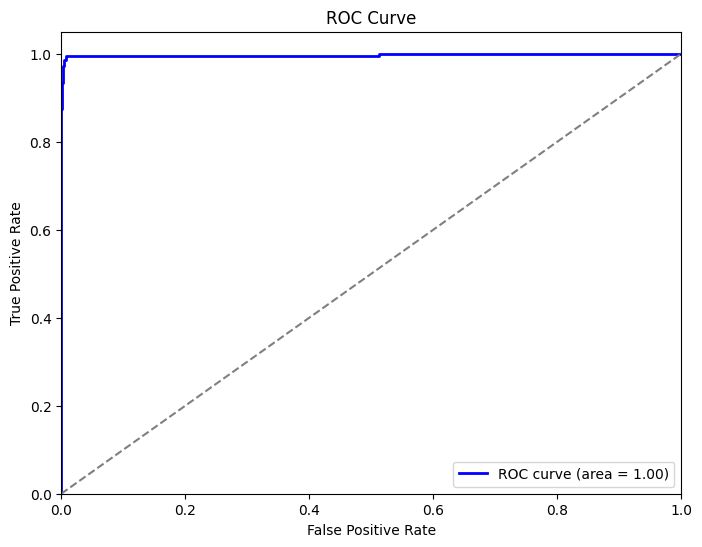

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC curve
y_val_binarized = label_binarize(y_val_true, classes=np.arange(len(unique_chars)))
y_pred_prob = model.predict(X_val)

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(y_val_binarized.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


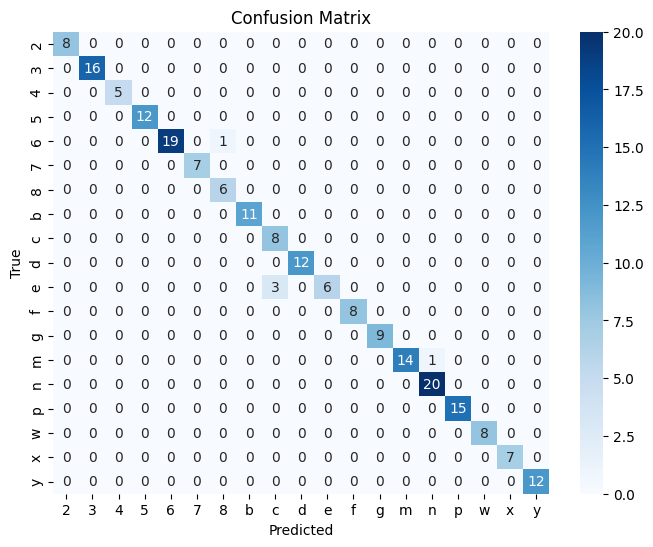

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix for true vs predicted labels
conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_chars, yticklabels=unique_chars)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()





In [15]:
from sklearn.metrics import accuracy_score

# y_val_true: array of true labels (e.g. np.argmax(y_val, axis=1))
# y_val_pred: array of predicted labels (e.g. np.argmax(model.predict(X_val), axis=1))

accuracy = accuracy_score(y_val_true, y_val_pred)
accuracy_percentage = accuracy * 100
print(f"Overall Accuracy: {accuracy_percentage:.2f}%")


Overall Accuracy: 97.60%


In [17]:
from scipy import stats

# Assuming y_val_true and y_val_pred are the true and predicted values, respectively
z_stat, p_value_z = stats.ttest_1samp(y_val_pred - y_val_true, 0)
print(f"Z-statistic: {z_stat:.4f}, P-value: {p_value_z:.4f}")
if p_value_z < 0.05:
    print("Significant difference detected (potential overfitting)")


Z-statistic: -0.7268, P-value: 0.4682


In [18]:
t_stat, p_value_t = stats.ttest_ind(y_val_true, y_val_pred)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value_t:.4f}")
if p_value_t < 0.05:
    print("Significant difference detected (potential overfitting)")


T-statistic: 0.0267, P-value: 0.9787


In [19]:
from scipy.stats import f_oneway

# Assuming you have:
# y_val_true   # array of true labels as integer indices, shape (n_samples,)
# y_pred_prob  # array of softmax outputs, shape (n_samples, n_classes)

# 1. Extract the predicted probability assigned to the true class for each sample
true_class_prob = y_pred_prob[np.arange(len(y_val_true)), y_val_true]

# 2. Build one group of probabilities for each true class
groups = [true_class_prob[y_val_true == c] for c in range(len(unique_chars))]

# 3. Perform one‐way ANOVA across all classes
f_stat, p_value_anova = f_oneway(*groups)

print(f"ANOVA F-statistic: {f_stat:.4f}, P-value: {p_value_anova:.4f}")
if p_value_anova < 0.05:
    print("Significant difference detected (potential overfitting)")
else:
    print("No significant difference detected")


ANOVA F-statistic: 8.5567, P-value: 0.0000
Significant difference detected (potential overfitting)
